In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
import math
from tensorly.decomposition import parafac, non_negative_parafac, non_negative_parafac_hals, tucker
from scipy.interpolate import interp1d
import tlviz

In [18]:
matrices = []
for i in range(16):
    sheet_index = 2*i
    file_path = 'TCR_seq_new.xlsx'
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='Day').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('Day ')[1].strip() for col in tcr_counts.columns]
    tcr_counts = tcr_counts[sorted(tcr_counts.columns, key=lambda x: int(x))]
    tcr_counts = tcr_counts.where(~(tcr_counts.isna()), 0)
    matrix = tcr_counts.sort_values(by=tcr_counts.columns[0], ascending=False, kind="mergesort").head(100)
    matrices.append(matrix)

In [19]:
matrices_freq = []
matrices_freq_total = []
for i in range(16):
    sheet_index = 2*i+1
    file_path = 'TCR_seq_new.xlsx'
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='Day').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('Day ')[1].strip() for col in tcr_counts.columns]
    tcr_counts = tcr_counts[sorted(tcr_counts.columns, key=lambda x: int(x))]
    tcr_counts = tcr_counts.where(~(tcr_counts.isna()), 0)
    matrix = tcr_counts.sort_values(by=tcr_counts.columns[0], ascending=False, kind="mergesort").head(100)
    matrices_freq.append(matrix)
    matrix = tcr_counts.sort_values(by=tcr_counts.columns[0], ascending=False, kind="mergesort").iloc[100:]
    matrices_freq_total.append(matrix)

In [20]:
def interpolate_matrix(matrix, step=10):
    original_cols = np.array(matrix.columns, dtype=float)
    
    start = original_cols[0]
    end = original_cols[-1]
    target_end = math.trunc(end/10)*10
    
    target_columns = np.arange(start, target_end + step, step)
    
    matrix_values = matrix.values
    n_rows = matrix_values.shape[0]
    
    interpolated_matrix = np.zeros((n_rows, len(target_columns)))
    
    for i in range(n_rows):
        f = interp1d(original_cols, matrix_values[i], kind='linear', fill_value='extrapolate')
        interpolated_matrix[i] = f(target_columns)
    
    interpolated_df = pd.DataFrame(interpolated_matrix, index=matrix.index, columns=target_columns)
    
    return interpolated_df

In [21]:
def plotting_interpolated_df(ax, df, title):
    x_values = df.columns.astype(float)
    
    # Plot each row as a separate line
    for idx, row in df.iterrows():
        ax.plot(x_values, row, alpha=0.6, label=str(idx))
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.grid(True)

In [22]:
interpolated = []
for i in matrices:
    interpolated.append(interpolate_matrix(i))
interpolated_freq = []
for i in matrices_freq:
    interpolated_freq.append(interpolate_matrix(i))
interpolated_freq_total = []
for i in matrices_freq_total:
    interpolated_freq_total.append(interpolate_matrix(i))

In [23]:
interpolated_norm = []
for i in interpolated:
    interpolated_norm.append(i.div(i.sum()))

In [24]:
del matrices[4]
del interpolated_freq[4]
del interpolated_norm[4]
del interpolated_freq_total[4]

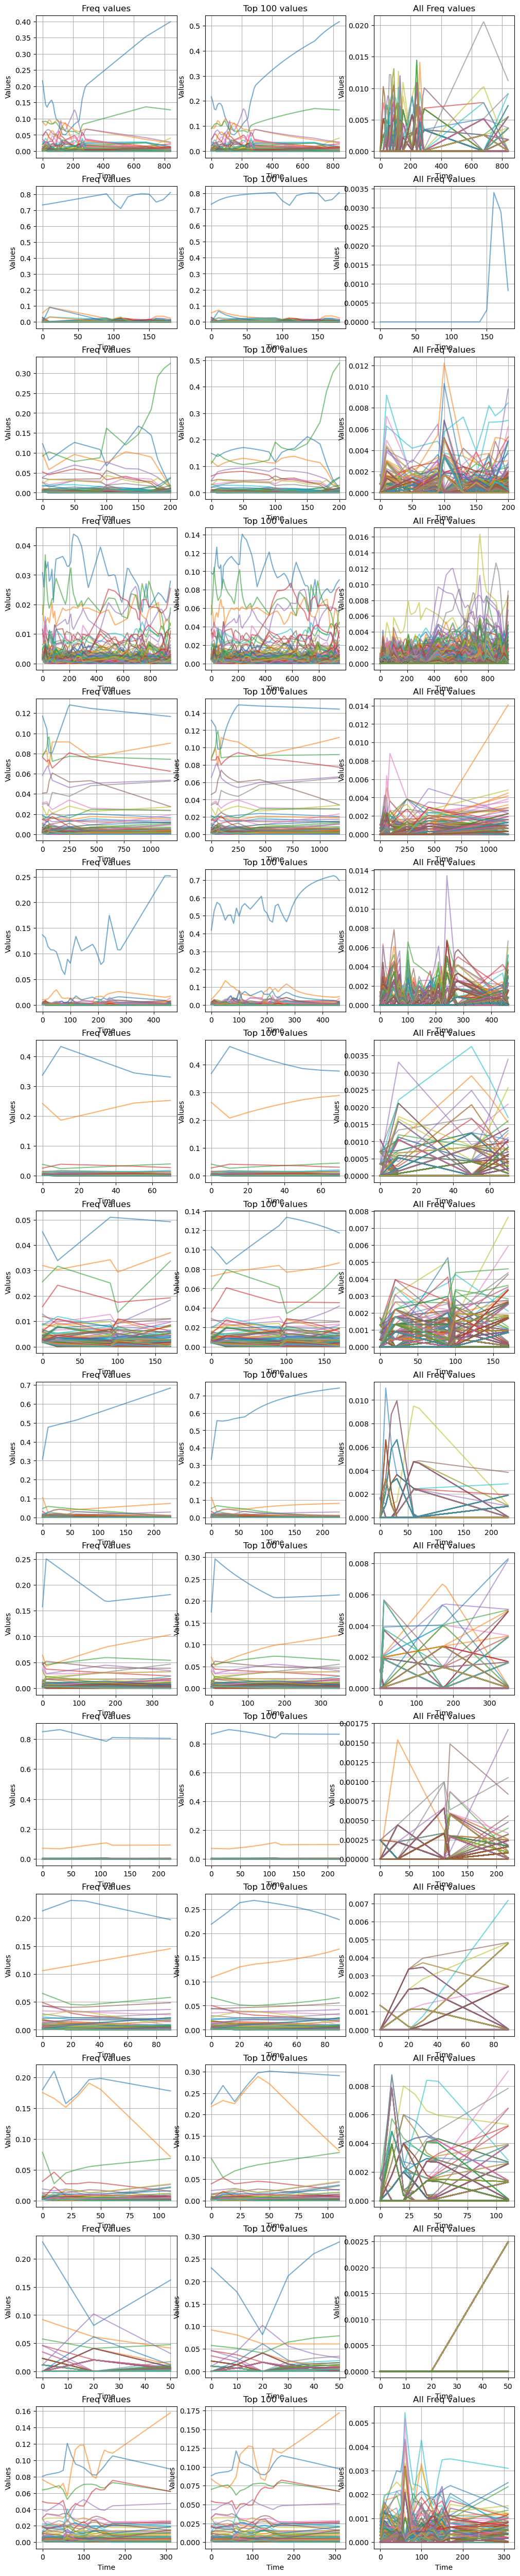

In [25]:
fig, ax = plt.subplots(15, 3, figsize=(12, 64))
for i in range(len(matrices)):
    plotting_interpolated_df(ax[i, 0], interpolated_freq[i], "Freq values")
    plotting_interpolated_df(ax[i, 1], interpolated_norm[i], "Top 100 values")
    plotting_interpolated_df(ax[i, 2], interpolated_freq_total[i], "All Freq values")

In [26]:
def plotting_interpolated_df_limit(ax, df, title, value):
    x_values = df.columns.astype(float)
    
    # Plot each row as a separate line
    for idx, row in df.iterrows():
        ax.plot(x_values, row, alpha=0.6, label=str(idx))
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim(0, value)

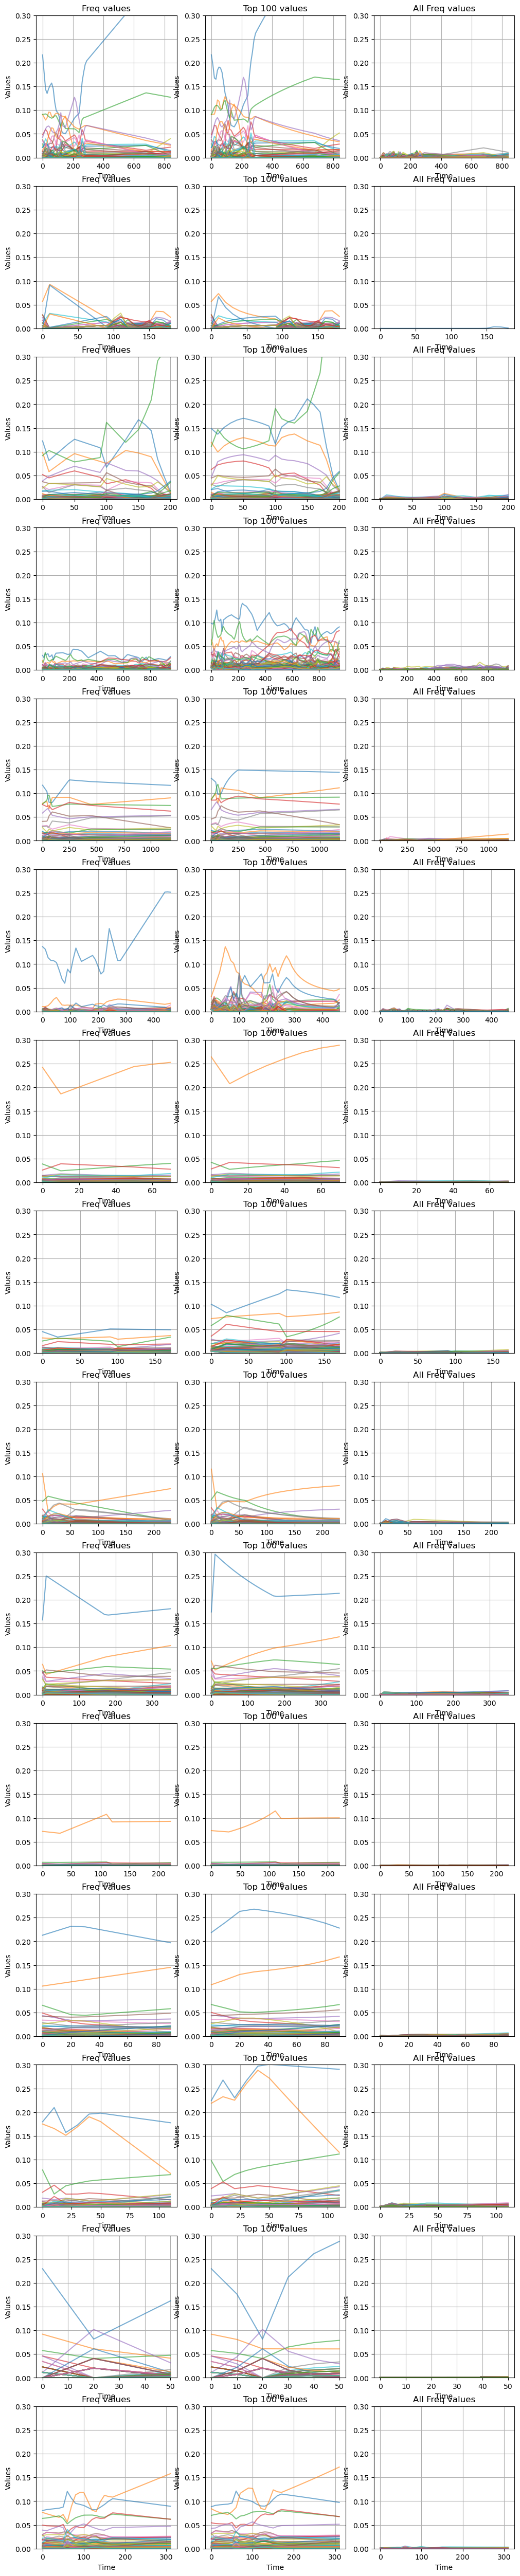

In [27]:
fig, ax = plt.subplots(15, 3, figsize=(12, 64))
for i in range(len(matrices)):
    plotting_interpolated_df_limit(ax[i, 0], interpolated_freq[i], "Freq values", 0.3)
    plotting_interpolated_df_limit(ax[i, 1], interpolated_norm[i], "Top 100 values", 0.3)
    plotting_interpolated_df_limit(ax[i, 2], interpolated_freq_total[i], "All Freq values", 0.3)

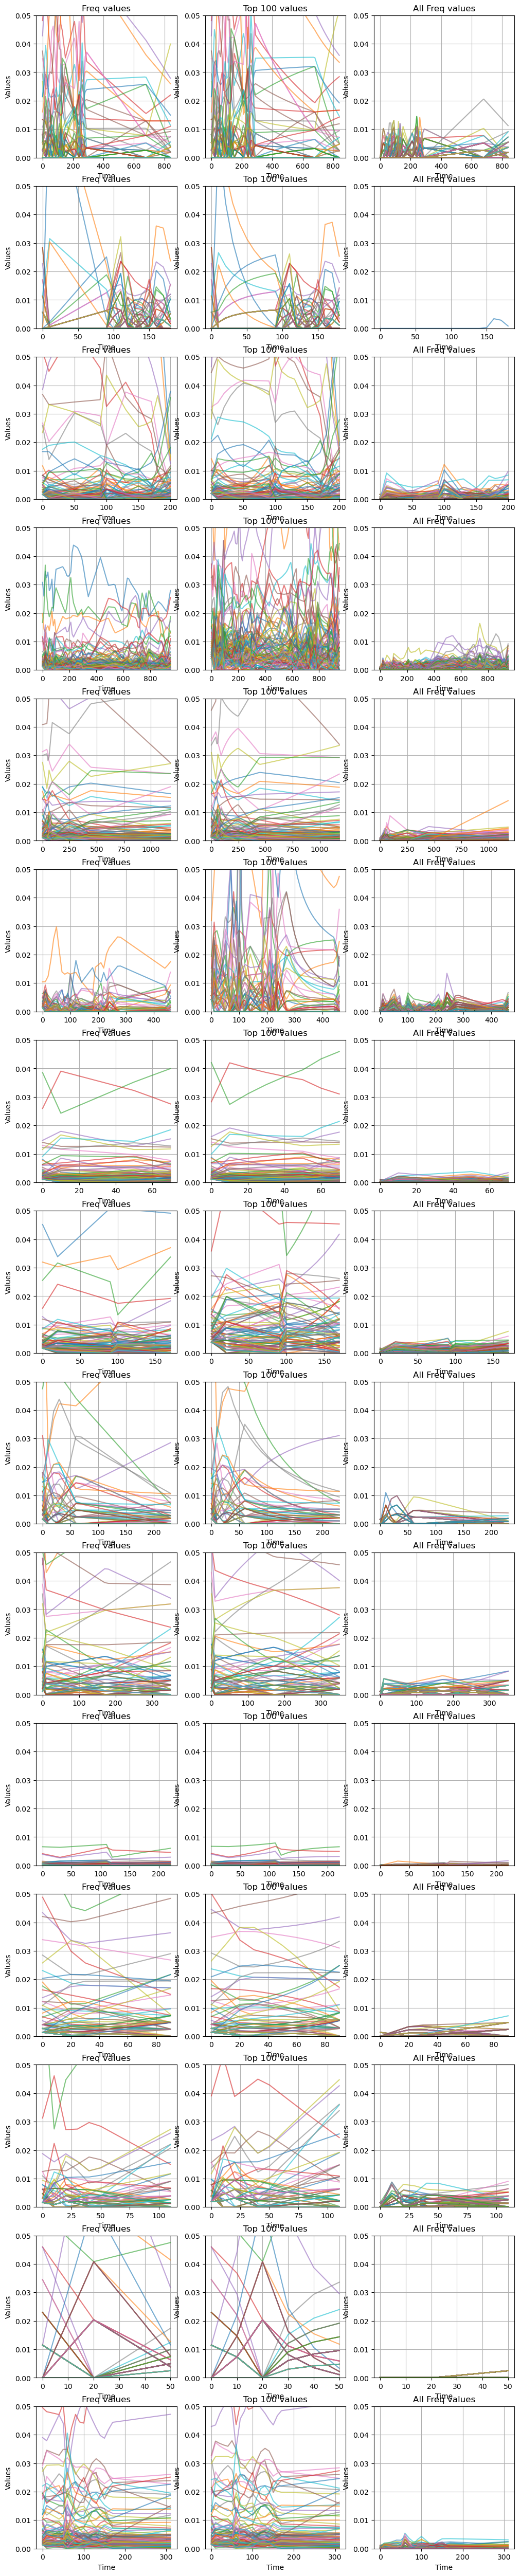

In [28]:
fig, ax = plt.subplots(15, 3, figsize=(12, 64))
for i in range(len(matrices)):
    plotting_interpolated_df_limit(ax[i, 0], interpolated_freq[i], "Freq values", 0.05)
    plotting_interpolated_df_limit(ax[i, 1], interpolated_norm[i], "Top 100 values", 0.05)
    plotting_interpolated_df_limit(ax[i, 2], interpolated_freq_total[i], "All Freq values", 0.05)